In [27]:
import sys  
sys.path.insert(0, '/home/yuxiao/nii_project/src')

# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

In [28]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
val_csv = config.val_csv
val_dir = config.val_dir

In [40]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["anchor", "negative", "positive"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image0_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 2])

        # Loading the image
        img0 = Image.open(image0_path)
        img1 = Image.open(image1_path)
        img2 = Image.open(image2_path)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img2 = img2.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (
            img0,
            img1,
            img2,
        )

    def __len__(self):
        return len(self.train_df)

In [41]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

eval_dataset = SiameseDataset(
    val_csv,
    val_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2, input3):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)

        return output1, output2, output3

In [59]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = nn.TripletMarginLoss(margin=5.0, p=2)
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.00005)

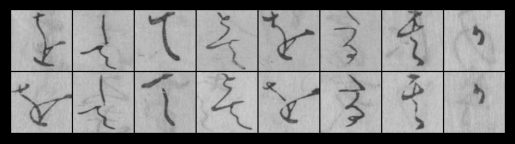

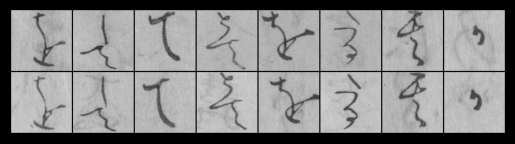

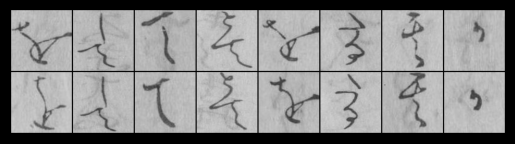

In [46]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))

concatenated = torch.cat((example_batch[0], example_batch[2]), 0)
imshow(torchvision.utils.make_grid(concatenated))

concatenated = torch.cat((example_batch[1], example_batch[2]), 0)
imshow(torchvision.utils.make_grid(concatenated))

In [57]:
# train the model
def train(
    model, device, criterion, optimizer, train_dataloader, train_losses, t_correct_set
):
    model.train()
    train_loss = 0
    correct = 0

    for _, (anchor, negative, positive) in enumerate(train_dataloader, 0):
        anchor, positive, negative = (
            anchor.to(device),
            positive.to(device),
            negative.to(device),
        )
        optimizer.zero_grad()
        output0, output1, output2 = model(anchor, positive, negative)
        loss = criterion(output0, output1, output2)
        train_loss += loss
        loss.backward()
        optimizer.step()
        euclidean_distance = F.pairwise_distance(output0, output1)
        pred = torch.where(
            euclidean_distance > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += len(pred) - pred.sum()

    train_loss /= len(train_dataloader.dataset)
    print(
        "\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            train_loss,
            correct,
            len(train_dataloader.dataset),
            100.0 * correct / len(train_dataloader.dataset),
        )
    )
    train_losses.append(train_loss.cpu().detach().numpy())
    t_correct_set.append(correct / len(train_dataloader.dataset))
    return train_loss


def eval(model, device, criterion, eval_dataloader, val_losses, v_correct_set):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for _, (anchor, negative, positive) in enumerate(train_dataloader, 0):
            anchor, positive, negative = (
                anchor.to(device),
                positive.to(device),
                negative.to(device),
            )
            output0, output1, output2 = model(anchor, positive, negative)
            loss = criterion(output0, output1, output2)
            val_loss += loss
            euclidean_distance = F.pairwise_distance(output0, output1)
            print(euclidean_distance)
            pred = torch.where(
                euclidean_distance > 0.5, 1, 0
            )  # get the index of the max log-probability
            correct += len(pred) - pred.sum()

    val_loss /= len(eval_dataloader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            val_loss,
            correct,
            len(eval_dataloader.dataset),
            100.0 * correct / len(eval_dataloader.dataset),
        )
    )
    return val_loss

In [58]:
val_losses = []
train_losses = []
t_correct_set = []
v_correct_set = []
best_eval_loss = 999

for epoch in tqdm(range(1, config.epochs)):
    train_loss = train(
        model,
        device,
        criterion,
        optimizer,
        train_dataloader,
        train_losses,
        t_correct_set,
    )
    val_loss = eval(
        model, device, criterion, test_dataloader, val_losses, v_correct_set
    )

    print("-" * 20)

    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        print(f"Best Eval loss: {best_eval_loss}")
        torch.save(model.state_dict(), "../siamese/content/model_triplet.pth")
        print("Model Saved Successfully")
        print("-" * 20)

  0%|          | 0/19 [00:00<?, ?it/s]


Train set: Average loss: 0.0020, Accuracy: 0/1668 (0%)
tensor([1.9157, 0.8234, 2.0628, 3.9641, 4.8999, 3.4209, 8.0207, 2.8853, 3.5038,
        3.7078, 3.9203, 3.4958, 3.0318, 3.8250, 2.6426, 6.1902, 3.0686, 4.1163,
        3.3269, 5.0988, 4.4006, 3.7705, 3.7259, 3.3525, 5.6323, 6.2585, 7.6321,
        1.6547, 6.8474, 3.1718, 2.8757, 3.9328], device='cuda:0')
tensor([4.6196, 6.7022, 5.7868, 6.3432, 3.8692, 4.9846, 2.4744, 2.1696, 1.3426,
        5.4641, 2.6503, 4.4307, 3.5747, 6.8659, 3.0964, 3.4980, 4.6577, 2.8209,
        4.1768, 1.5912, 5.6990, 4.7829, 5.3567, 2.8117, 2.7880, 2.9535, 2.4300,
        1.2417, 4.1567, 6.2259, 2.0704, 3.2418], device='cuda:0')
tensor([2.7541, 3.4189, 8.4843, 3.9884, 6.4901, 3.8403, 4.4025, 5.7212, 1.3281,
        3.4238, 2.6384, 1.2996, 3.7261, 2.7562, 6.1309, 4.6152, 2.6056, 2.5706,
        2.6052, 2.3574, 2.2567, 8.5449, 2.8995, 4.7589, 3.5770, 2.7645, 3.6939,
        3.4338, 2.4877, 3.8131, 2.2432, 2.0064], device='cuda:0')
tensor([4.3622, 2.9266, 3.

  5%|▌         | 1/19 [00:08<02:29,  8.29s/it]

tensor([1.6278, 2.9826, 4.5188, 5.4042, 4.4806, 5.3052, 2.5764, 1.8045, 3.1580,
        4.2302, 3.2170, 1.5915, 2.9791, 5.6112, 5.5791, 2.8403, 1.8742, 3.8950,
        2.3532, 4.2730, 2.4302, 3.3533, 2.7577, 5.4114, 2.5681, 5.7616, 3.6436,
        2.9111, 4.5130, 2.9963, 2.1497, 4.3006], device='cuda:0')
tensor([2.7562, 1.8074, 4.0884, 3.9586, 2.6721, 3.7349, 3.7287, 2.6792, 4.7851,
        3.9874, 3.0834, 3.3375, 4.5086, 3.0806, 3.9523, 1.3918, 5.4931, 2.7225,
        3.3014, 5.7296, 2.6037, 4.7171, 4.2207, 3.9543, 6.3660, 3.7797, 5.4135,
        4.2657, 5.1454, 3.2161, 4.6043, 4.7562], device='cuda:0')
tensor([1.7947, 2.5255, 4.6341, 2.1181], device='cuda:0')

Test set: Average loss: 0.0058, Accuracy: 0/557 (0%)

--------------------
Best Eval loss: 0.005767180118709803
Model Saved Successfully
--------------------

Train set: Average loss: 0.0019, Accuracy: 0/1668 (0%)
tensor([1.3041, 3.2925, 3.1157, 3.4032, 4.6351, 3.3670, 2.7771, 2.5827, 1.3764,
        2.7217, 1.9862, 1.2322, 5.9

 11%|█         | 2/19 [00:16<02:21,  8.30s/it]

tensor([2.8227, 4.8155, 4.0398, 4.0936, 3.7853, 3.2175, 3.1920, 2.0044, 8.2250,
        2.3085, 5.9315, 3.9566, 1.5979, 1.8498, 2.6688, 3.6316, 2.8552, 2.7430,
        6.2502, 4.9493, 5.3775, 6.4240, 8.6630, 3.5796, 3.7119, 1.6977, 1.5723,
        3.3743, 0.6654, 2.7406, 1.8407, 2.7440], device='cuda:0')
tensor([3.2918, 1.8303, 3.4452, 3.4008, 4.4136, 4.2962, 4.6506, 3.4596, 3.5243,
        2.9460, 4.5626, 7.5454, 2.7310, 3.6183, 1.8584, 5.9675, 2.8433, 3.8099,
        4.6209, 5.1441, 2.0545, 5.1556, 3.2818, 2.7927, 1.6622, 4.2519, 5.3258,
        5.8399, 3.2013, 2.1486, 1.7227, 2.6692], device='cuda:0')
tensor([3.5001, 2.7141, 4.2221, 3.1314], device='cuda:0')

Test set: Average loss: 0.0051, Accuracy: 0/557 (0%)

--------------------
Best Eval loss: 0.0051360297948122025
Model Saved Successfully
--------------------

Train set: Average loss: 0.0024, Accuracy: 0/1668 (0%)
tensor([2.9714, 2.1925, 3.6363, 3.5523, 2.3533, 5.1181, 3.8584, 3.0346, 4.2823,
        3.9898, 3.0251, 2.1103, 2.

 16%|█▌        | 3/19 [00:24<02:11,  8.24s/it]

tensor([2.9422, 2.6351, 1.5221, 2.2225, 3.9408, 2.6213, 4.2584, 2.9797, 6.1246,
        4.0530, 4.3830, 3.2780, 4.8843, 4.8058, 5.1186, 3.4012, 1.6339, 4.1270,
        2.6084, 4.8531, 3.1188, 2.4807, 2.9641, 2.2178, 1.9643, 4.3244, 4.8933,
        2.4900, 3.9548, 1.7539, 4.8521, 2.3790], device='cuda:0')
tensor([1.5154, 4.5187, 1.8396, 1.8552, 4.6576, 3.7609, 2.0224, 1.0513, 4.3656,
        7.0697, 2.5300, 3.8529, 3.0633, 5.5792, 3.9700, 5.0478, 5.9793, 4.9451,
        1.6283, 3.6192, 5.0927, 2.0536, 1.9779, 2.7669, 2.6926, 3.5185, 2.5787,
        2.9174, 2.7099, 3.9463, 1.8199, 2.4281], device='cuda:0')
tensor([4.0573, 3.3894, 3.9773, 2.8633], device='cuda:0')

Test set: Average loss: 0.0043, Accuracy: 0/557 (0%)

--------------------
Best Eval loss: 0.004291437100619078
Model Saved Successfully
--------------------

Train set: Average loss: 0.0020, Accuracy: 0/1668 (0%)
tensor([2.4395, 2.3867, 2.3684, 2.6970, 1.6457, 3.1141, 2.7936, 2.0038, 4.3022,
        2.1976, 2.9869, 2.8473, 4.7

 16%|█▌        | 3/19 [00:31<02:46, 10.40s/it]

tensor([2.1372, 3.0963, 3.1066, 2.5199, 6.5163, 4.5862, 4.5797, 3.1269, 2.4655,
        3.9862, 2.1653, 2.8501, 1.6362, 2.7627, 4.4102, 2.8315, 2.9016, 4.2256,
        1.8350, 4.0109, 2.0006, 2.6052, 4.8247, 1.8507, 2.5800, 3.1657, 5.2718,
        4.3256, 2.6510, 4.5791, 4.2681, 1.5359], device='cuda:0')
tensor([2.7727, 3.4171, 3.0891, 1.9832, 3.9080, 3.2428, 4.1471, 1.8310, 2.6436,
        4.8834, 5.6446, 1.6183, 2.6002, 2.1222, 0.7678, 0.7604, 1.9792, 3.0166,
        4.5719, 3.1155, 2.7179, 2.8496, 4.6739, 5.5655, 2.9525, 1.1419, 5.3966,
        1.8744, 3.4196, 4.9454, 3.6675, 3.7563], device='cuda:0')


KeyboardInterrupt: 

In [51]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for images_1, images_2, targets in test_dataloader:
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        output1, output2 = model(images_1, images_2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred = torch.where(
            euclidean_distance > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
print(
    "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss,
        correct,
        len(test_dataloader.dataset),
        100.0 * correct / len(test_dataloader.dataset),
    )
)


Test set: Average loss: 0.0000, Accuracy: 1740/1820 (96%)



In [52]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

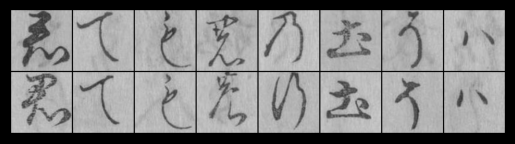

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [53]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [54]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = (
    images_1.to(device),
    images_2.to(device),
    targets.to(device),
)
output1, output2 = model(images_1, images_2)
euclidean_distance = F.pairwise_distance(output1, output2)
pred = torch.where(
    euclidean_distance > 0.5, 1, 0
)  # get the index of the max log-probability

In [55]:
euclidean_distance

tensor([1.5400, 0.1231, 0.2166, 1.2534, 0.9874, 1.7099, 0.6917, 0.0492],
       device='cuda:0', grad_fn=<NormBackward1>)

In [56]:
pred

tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')